# Figure 2. scRiskCell performance and application.

*Xuqin Xie*  
*2025/05/25*

(A) Schematic of scRiskCell. DEGs: differentially expressed genes; GRNs: gene regulatory networks. (B) Bar graphs demonstrating the percentage of beta risk and non-risk cells in each donor. ND n = 49; preT2D n = 23; T2D n = 34. Two-sided Wilcoxon rank-sum test. P-values were adjusted for multiple comparisons using the Benjamini-Hochberg (BH) method. Significance levels: * p.adj < 0.05, ** p.adj < 0.01, *** p.adj < 0.001. (C) ROC curve of support vector machine (SVM)-based model for disease states prediction (ND, preT2D, and T2D) using beta risk cell proportions. Shaded areas represent 95% confidence intervals estimated from 2,000 bootstrap replicates. (D–E) Pearson correlation between beta risk cell ratio and HbA1c (D, n = 105), and C-peptide (E, n = 31). Pearson correlation was assessed using a two-sided t-test for the correlation coefficient. The bands around the linear regression line represent the range of 95% confidence interval of the risk cell ratio. (F) Differentially expressed genes (DEGs) at the pseudobulk level between risk and non-risk of beta cells. Genes with an adjusted p-value < 0.05 were considered statistically differentially expressed. Adjusted p-values were derived from pseudobulk differential expression analysis using DESeq2 with BH correction. (Bottom) Violin plots highlight examples of DEGs with different dysregulation directions between risk and non-risk beta cells. (G) Venn diagrams of unique/shared genes targeted by NEUROD1, ATF4, ATF6, and XBP1 in risk and non-risk beta cells. Example of genes in each category is listed at the bottom of each graph.

***

##### **Figure 2(A) and 2(G)** was created using Adobe Illustrator (AI) to visually present the conceptual design.
##### **Figures 2(B) and 2(C)** were generated using the Python environment.
##### **Figures 2(D-F)** were generated using the R environment.

---

### Figure 2(B)
The significance symbols were derived from the boxplot.

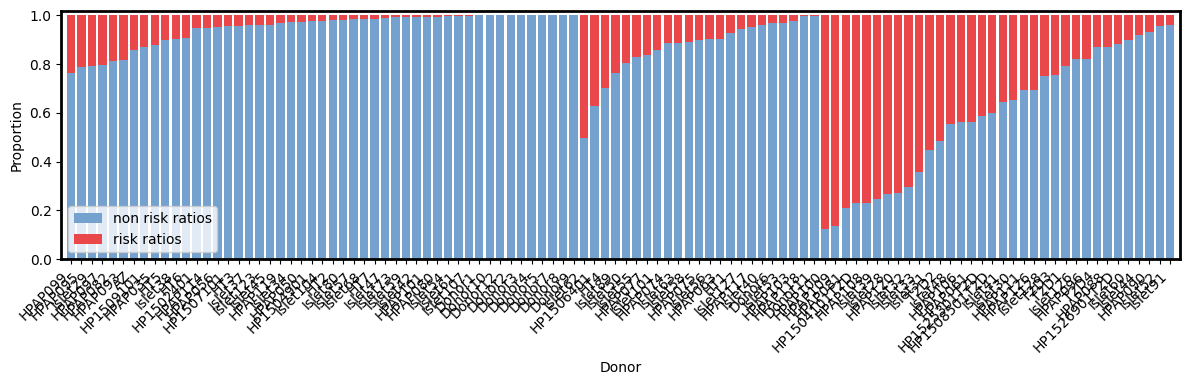

In [2]:
import pandas as pd
import numpy as np
import scRiskCell

donor_risk_ratio = pd.read_csv("./beta_donorRiskRatio.csv")
scRiskCell.PlotRatioStackBar(donor_risk_ratio,x='disease',y='risk ratios',groups='disease',colors=[ '#74a1ce','#e9474a'],figsize=(12,4))

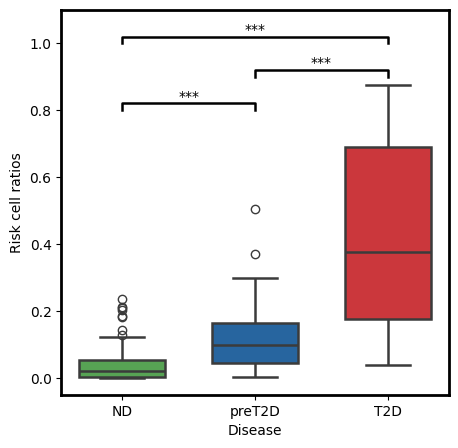

In [6]:
scRiskCell.PlotRatioBoxplot(state=0,df=donor_risk_ratio,x='disease',y='risk ratios',groups='disease',colors=['#4bb047', '#1366b3', '#e41e25'],width=0.65,linewidth=1.8,pYLoc1=0.8,pYLoc2=0.9,pYLoc3=1.0,figsize=(5,5))

### Figure 2(C)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

def PlotMultiROC(state, model, df, colors, title, figsize):
    if state == 0:
        X, y = df[['risk ratios']], df.label
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        y_test_01 = label_binarize(y_test, classes=np.arange(3))
        
        fpr = {}
        tpr = {}
        roc_auc = {}
        plt.figure(figsize=figsize)
        for i in range(3):
            fpr[i], tpr[i], _ = roc_curve(y_test_01[:, i], model.predict_proba(X_test)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

            # Calculate confidence interval
            n_bootstraps = 2000
            bootstrapped_scores = []

            for _ in range(n_bootstraps):
                indices = resample(np.arange(len(y_test)), replace=True)
                if len(np.unique(y_test_01[indices, i])) < 2:
                    continue
                
                fpr_, tpr_, _ = roc_curve(y_test_01[indices, i], model.predict_proba(X_test)[indices, i])
                bootstrapped_scores.append(auc(fpr_, tpr_))

            bootstrapped_scores = np.array(bootstrapped_scores)
            lower_bound = np.percentile(bootstrapped_scores, 2.5)
            upper_bound = np.percentile(bootstrapped_scores, 97.5)

            # Calculate upper and lower bounds for TPR
            tpr_upper = np.clip(tpr[i] + 0.1, 0, 1)  # Example upper bound
            tpr_lower = np.clip(tpr[i] - 0.1, 0, 1)  # Example lower bound
            
            # Plot ROC curve and fill confidence intervals
            plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:0.3f})')
            plt.fill_between(fpr[i], tpr_lower, tpr_upper, color=colors[i], alpha=0.2)

        plt.plot([0, 1], [0, 1], '--', lw=2, color='gray')
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        plt.gca().spines['top'].set_linewidth(2)
        plt.gca().spines['bottom'].set_linewidth(2)
        plt.gca().spines['left'].set_linewidth(2)
        plt.gca().spines['right'].set_linewidth(2)
        
    elif state == 1:
        X, y = df[['risk ratios']], df.label
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
        roc_auc = auc(fpr, tpr)

        # Calculate confidence interval
        n_bootstraps = 2000
        bootstrapped_scores = []
        
        plt.figure(figsize=figsize)
        for _ in range(n_bootstraps):
            indices = resample(np.arange(len(y_test)), replace=True)
            if len(np.unique(y_test[indices])) < 2:
                continue

            fpr_, tpr_, _ = roc_curve(y_test[indices], model.predict_proba(X_test)[indices, 1])
            bootstrapped_scores.append(auc(fpr_, tpr_))

        bootstrapped_scores = np.array(bootstrapped_scores)
        lower_bound = np.percentile(bootstrapped_scores, 2.5)
        upper_bound = np.percentile(bootstrapped_scores, 97.5)

        # Calculate upper and lower bounds for TPR
        tpr_upper = np.clip(tpr + 0.1, 0, 1)  # Example upper bound
        tpr_lower = np.clip(tpr - 0.1, 0, 1)  # Example lower bound

        plt.figure(figsize=figsize)
        plt.plot(fpr, tpr, color=colors[0], lw=2, label='ROC curve (AUC = {0:0.3f})'.format(roc_auc))

        # Fill confidence interval
        plt.fill_between(fpr, tpr_lower, tpr_upper, color=colors[0], alpha=0.2)

        plt.plot([0, 1], [0, 1], '--', lw=2, color='gray')
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
        plt.gca().spines['top'].set_linewidth(2)
        plt.gca().spines['bottom'].set_linewidth(2)
        plt.gca().spines['left'].set_linewidth(2)
        plt.gca().spines['right'].set_linewidth(2)

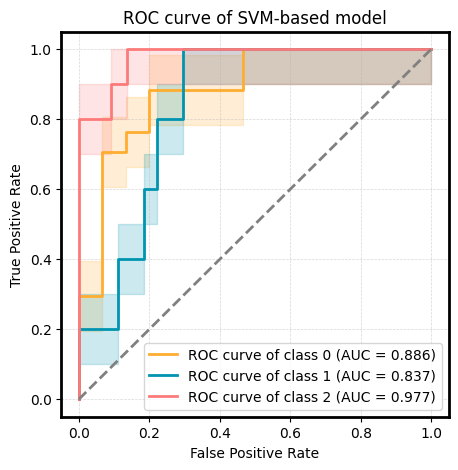

In [12]:
svm_model = scRiskCell.GetSVMClassifier(state=0,df=donor_risk_ratio)
PlotMultiROC(state=0,model=svm_model,df=donor_risk_ratio,colors=['#ffad2f','#0094b0','#fc7a7a'],title='ROC curve of SVM-based model',figsize=(5,5))